In [1]:
#import libs
import cv2
import numpy as np
import time
import pandas as pd
import os
import pydicom
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from pydicom.filereader import read_dicomdir
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import patches
style.use('ggplot')
import h5py
%matplotlib inline
import math

In [2]:
#Extracting dataframe
df = pd.read_csv('../data/stage_2_train_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [3]:
#Length of dataframe
len(df)

30227

In [4]:
#getting cases only of pneumonia
df_1=0
df_1=df[df['Target']==1]
length1=len(df_1)
df_1.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [5]:
#creating a dataframe with the patient ids which have bounding boxes and there count
df_id_vc=pd.DataFrame(df_1['patientId'].value_counts())
df_id_vc.reset_index(inplace=True)
df_id_vc.rename(columns={"index":"patientId","patientId":"vc"},inplace=True)
df_id_vc=df_id_vc[df_id_vc.vc>=1]
print(df_id_vc.shape)
df_id_vc.head()

(6012, 2)


,patientId,vc
0,31764d54-ea3b-434f-bae2-8c579ed13799,4
1,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,4
2,32408669-c137-4e8d-bd62-fe8345b40e73,4
3,3239951b-6211-4290-b237-3d9ad17176db,4
4,7d674c82-5501-4730-92c5-d241fd6911e7,4


In [6]:
#checking above dataframe
df_id_vc.tail()

,patientId,vc
6007,4206173d-0db2-4f32-80fb-0bd99d5532e1,1
6008,84309ddd-319f-4e6d-b312-2bc70537b074,1
6009,1693a790-88c8-46fa-9ce7-3b0c5834ba90,1
6010,f7d0e9c2-68d8-4742-9ce6-1ac3d250cb35,1
6011,254d15d9-dfc5-42a2-b2d6-f208527d6396,1


In [7]:
#chinging column position
df_1=df_1[['patientId','Target','x','y','width','height']]

In [8]:
#selecting length of dataset based on bound box count
k = len(df_id_vc)
k

6012

In [9]:
#seeing length of dataset with pneumonia cases only
len(df_1)

9555

In [10]:
#Storing coordinates into a variable
coords = np.zeros((k, 4, 4), dtype=float)
count=0
for i in range(k):
    bb=np.array(df_1[df_1['patientId']==df_id_vc.iloc[i,0]])
    count=count+1
    for j,q in enumerate(bb):
        coords[i][j,0]= float(q[2])
        coords[i][j,1] = float(q[3])
        coords[i][j,2] = float(q[4])
        coords[i][j,3] = float(q[5]) 
    
    
print(count)

6012


In [11]:
#print shape of data
#print(X_train.shape)
print(coords.shape)

(6012, 4, 4)


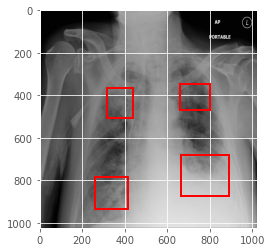

In [12]:
#printing 1 sample image along with coordinates
n=12
fig,ax = plt.subplots(1)
ds1 = pydicom.read_file('C:\\Users\\sarth\\Anaconda projects\\great learning\\AI\\Capstone\\CV\\data\\stage_2_train_images\\'+df_id_vc.iloc[n,0]+'.dcm')
ax.imshow(ds1.pixel_array, cmap=plt.cm.gray)
rect = patches.Rectangle((coords[n][0,0], coords[n][0,1]), (coords[n][0,2]) , (coords[n][0,3]) , linewidth=2, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((coords[n][1,0], coords[n][1,1]), (coords[n][1,2]) , (coords[n][1,3]) , linewidth=2, edgecolor='r', facecolor='none')
rect3 = patches.Rectangle((coords[n][2,0], coords[n][2,1]), (coords[n][2,2]) , (coords[n][2,3]) , linewidth=2, edgecolor='r', facecolor='none')
rect4 = patches.Rectangle((coords[n][3,0], coords[n][3,1]), (coords[n][3,2]) , (coords[n][3,3]) , linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
plt.show()

### YOLO IMPLEMENTATION

In [13]:
#list all wts for our data
os.listdir('Final_wts')

['yolov3_custom_1000.weights',
 'yolov3_custom_2000.weights',
 'yolov3_custom_final.weights',
 'yolov3_custom_last.weights']

In [14]:
# Load Yolo
net = cv2.dnn.readNet("final_wts/yolov3_custom_last.weights", "yolov3_custom.cfg")
print(net)

<dnn_Net 000001D25E563ED0>


In [15]:
#See all classes 
classes = []
with open("obj.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
    
print(classes)

['pneumonia']


In [16]:
#To get all layers in yolo
layer_names = net.getLayerNames()
print(layer_names)

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

In [17]:
#To see output layers only
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print(output_layers)

['yolo_82', 'yolo_94', 'yolo_106']


In [18]:
#Clors for bound box
colors=0
colors = np.random.uniform(0, 255, size=(len(classes), 3))
print(colors)

[[232.17968194  18.31694383 218.68620813]]


In [19]:
# Loading image for a prediction and then resizing it to yolo input i.e 416*416
i=0
IMAGE_HEIGHT = 416
IMAGE_WIDTH = 416
img = cv2.imread("C:\\Users\\sarth\\Anaconda projects\\great learning\\AI\\Capstone\\CV\\anoteee\\images\\"+df_id_vc.iloc[i,0]+".jpg")
print(img.shape)
img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
height, width, channels = img.shape

(416, 416, 3)


In [20]:
#Blob conversion
# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
print(blob)
for bb in blob:
    for i,b in enumerate(bb):
        #cv2.imshow(str(i),b)
        pass
        
cv2.waitKey(0)
cv2.destroyAllWindows()

[[[[0.63112    0.67032003 0.67816    ... 0.03136    0.04312
    0.01568   ]
   [0.68992    0.72128    0.76832    ... 0.05488    0.03136
    0.0392    ]
   [0.70168    0.72912    0.79968    ... 0.0588     0.04704
    0.0392    ]
   ...
   [0.26264    0.30968    0.27048    ... 0.38416    0.36848
    0.3136    ]
   [0.23912    0.3332     0.30576    ... 0.36848    0.35672
    0.3136    ]
   [0.24304    0.30576    0.28224    ... 0.36064    0.33712
    0.32144   ]]

  [[0.63112    0.67032003 0.67816    ... 0.03136    0.04312
    0.01568   ]
   [0.68992    0.72128    0.76832    ... 0.05488    0.03136
    0.0392    ]
   [0.70168    0.72912    0.79968    ... 0.0588     0.04704
    0.0392    ]
   ...
   [0.26264    0.30968    0.27048    ... 0.38416    0.36848
    0.3136    ]
   [0.23912    0.3332     0.30576    ... 0.36848    0.35672
    0.3136    ]
   [0.24304    0.30576    0.28224    ... 0.36064    0.33712
    0.32144   ]]

  [[0.63112    0.67032003 0.67816    ... 0.03136    0.04312
    0.0156

In [21]:
net.setInput(blob)
outs = net.forward(output_layers)
print(outs)


[array([[5.2446209e-02, 4.6275653e-02, 5.2071512e-01, 1.6789033e-01,
        4.1341095e-06, 0.0000000e+00],
       [4.0592909e-02, 3.4915827e-02, 3.3439684e-01, 2.3535372e-01,
        4.6420237e-06, 0.0000000e+00],
       [2.3400653e-02, 3.9721675e-02, 4.4437903e-01, 1.5893675e-01,
        9.6148078e-06, 0.0000000e+00],
       ...,
       [9.5741868e-01, 9.5342869e-01, 2.6857617e-01, 1.3473772e-01,
        9.9152817e-07, 0.0000000e+00],
       [9.6218991e-01, 9.5182669e-01, 3.1182611e-01, 8.5155910e-01,
        7.7920117e-07, 0.0000000e+00],
       [9.6304232e-01, 9.6019566e-01, 7.1505386e-01, 4.4384542e-01,
        2.3758037e-06, 0.0000000e+00]], dtype=float32), array([[1.72819681e-02, 1.97406020e-02, 8.21869746e-02, 3.42892379e-01,
        6.10774305e-06, 0.00000000e+00],
       [2.40226220e-02, 2.68627293e-02, 1.42769799e-01, 1.02536716e-01,
        3.59350861e-06, 0.00000000e+00],
       [2.37656701e-02, 1.61690190e-02, 1.43361121e-01, 5.68245411e-01,
        5.82071925e-06, 0.0000

In [22]:
for out in outs:
    for detection in out:
        print(detection)

[5.2446209e-02 4.6275653e-02 5.2071512e-01 1.6789033e-01 4.1341095e-06
 0.0000000e+00]
[4.0592909e-02 3.4915827e-02 3.3439684e-01 2.3535372e-01 4.6420237e-06
 0.0000000e+00]
[2.3400653e-02 3.9721675e-02 4.4437903e-01 1.5893675e-01 9.6148078e-06
 0.0000000e+00]
[1.3273431e-01 4.8492569e-02 2.6756260e-01 1.6440384e-01 7.5472685e-06
 0.0000000e+00]
[1.2352813e-01 3.4270409e-02 2.5025088e-01 2.6346743e-01 5.3866561e-06
 0.0000000e+00]
[1.1386233e-01 4.5484606e-02 4.1663155e-01 1.6491701e-01 1.6281449e-05
 0.0000000e+00]
[1.9958912e-01 5.2345876e-02 2.5946933e-01 1.6223632e-01 6.4133778e-06
 0.0000000e+00]
[1.9136442e-01 4.6093132e-02 2.7652973e-01 4.3577909e-01 2.2885392e-06
 0.0000000e+00]
[2.0029339e-01 2.4408184e-02 6.1502099e-01 2.6845270e-01 5.0210660e-06
 0.0000000e+00]
[2.7514634e-01 4.8023421e-02 2.4303158e-01 1.2828349e-01 7.1636468e-06
 0.0000000e+00]
[2.6648924e-01 4.8674420e-02 2.7254769e-01 5.5984569e-01 3.0502556e-06
 0.0000000e+00]
[2.7539995e-01 2.9263359e-02 7.9627860e-01 

 0.0000000e+00]
[2.8725117e-01 2.1530159e-01 1.5855005e-01 1.2804313e-01 1.7686864e-06
 0.0000000e+00]
[2.9633722e-01 2.1554080e-01 1.6823697e-01 1.8354663e-01 2.0606944e-06
 0.0000000e+00]
[3.3031315e-01 2.2284643e-01 9.9573642e-02 1.3418294e-01 8.2122625e-07
 0.0000000e+00]
[3.3559167e-01 2.1807674e-01 1.9658473e-01 1.1667721e-01 8.9050136e-06
 0.0000000e+00]
[3.3780846e-01 2.1872208e-01 2.2058001e-01 2.2876635e-01 7.5809344e-06
 0.0000000e+00]
[3.6900622e-01 2.2425780e-01 7.0550613e-02 1.5330850e-01 1.5746766e-05
 0.0000000e+00]
[3.7211892e-01 2.1969265e-01 1.4244863e-01 1.2439282e-01 9.4381045e-05
 0.0000000e+00]
[3.7043968e-01 2.1944696e-01 1.5197061e-01 1.9393870e-01 5.0413662e-05
 0.0000000e+00]
[4.0179902e-01 2.2164144e-01 8.8567846e-02 1.4486319e-01 2.1608165e-04
 0.0000000e+00]
[0.40399578 0.21908551 0.10444316 0.11524092 0.00048261 0.        ]
[4.0106484e-01 2.2142980e-01 1.5573297e-01 2.0405489e-01 1.4244694e-04
 0.0000000e+00]
[4.3327376e-01 2.1762411e-01 1.0402895e-01 1.5

 0.0000000e+00]
[2.5683790e-01 3.3197513e-01 8.9670978e-02 1.9932111e-01 7.3217547e-07
 0.0000000e+00]
[2.5762188e-01 3.2924545e-01 1.3005319e-01 3.0579779e-01 3.2111689e-06
 0.0000000e+00]
[2.9430136e-01 3.3086982e-01 1.0084565e-01 1.6593033e-01 4.0078799e-06
 0.0000000e+00]
[2.99189210e-01 3.29960823e-01 1.17075495e-01 1.56456023e-01
 4.51334336e-06 0.00000000e+00]
[2.9831362e-01 3.3459011e-01 1.7292635e-01 2.8413704e-01 1.5584463e-05
 0.0000000e+00]
[3.3117729e-01 3.3082214e-01 1.0528273e-01 1.7007221e-01 4.9112979e-05
 0.0000000e+00]
[3.3602735e-01 3.2607153e-01 1.5133002e-01 1.4012517e-01 8.9714064e-05
 0.0000000e+00]
[0.33945432 0.33086947 0.18074784 0.28740174 0.00056668 0.        ]
[3.6843747e-01 3.2856065e-01 9.5895514e-02 1.6920429e-01 2.8135997e-04
 0.0000000e+00]
[0.36720964 0.3264014  0.13384697 0.13712586 0.00074237 0.        ]
[0.37002257 0.32994688 0.15838231 0.29925188 0.00993158 0.        ]
[3.9901847e-01 3.2699743e-01 8.5337266e-02 1.7388357e-01 6.8355694e-05
 0.0000

 0.0000000e+00]
[4.6981123e-01 5.5602527e-01 1.3374868e-01 1.8349423e-01 1.1214855e-06
 0.0000000e+00]
[4.7078753e-01 5.6126916e-01 1.0908808e-01 2.4032187e-01 2.9510659e-06
 0.0000000e+00]
[5.09020150e-01 5.58414161e-01 1.04975134e-01 2.12023407e-01
 2.06286722e-06 0.00000000e+00]
[5.13152480e-01 5.55604339e-01 1.07996576e-01 1.11499868e-01
 3.14388160e-07 0.00000000e+00]
[5.0985277e-01 5.6516886e-01 4.3870106e-02 3.4909889e-01 1.1176461e-06
 0.0000000e+00]
[5.5208278e-01 5.6084335e-01 1.1556204e-01 3.1105608e-01 1.1341416e-06
 0.0000000e+00]
[5.5470991e-01 5.5598438e-01 1.2509958e-01 1.3988127e-01 3.8639067e-07
 0.0000000e+00]
[5.5268878e-01 5.6421942e-01 4.6806972e-02 2.9131910e-01 4.4818805e-07
 0.0000000e+00]
[5.99509835e-01 5.56158662e-01 1.03263766e-01 2.80092865e-01
 2.73327572e-07 0.00000000e+00]
[5.9790599e-01 5.5942029e-01 1.7503947e-01 1.5153481e-01 1.8158954e-07
 0.0000000e+00]
[5.9944731e-01 5.5572778e-01 1.1719609e-01 2.2887237e-01 1.1524540e-07
 0.0000000e+00]
[6.422548

[5.1022595e-01 6.3665897e-01 8.9155830e-02 1.4952888e-01 3.4053176e-06
 0.0000000e+00]
[5.0793374e-01 6.2975663e-01 1.2125982e-01 1.4666441e-01 6.0688194e-07
 0.0000000e+00]
[5.0738913e-01 6.3715994e-01 5.7973985e-02 3.1288102e-01 1.6295677e-06
 0.0000000e+00]
[5.5165219e-01 6.3718009e-01 1.0520814e-01 3.2580596e-01 1.4557038e-06
 0.0000000e+00]
[5.5114925e-01 6.3138878e-01 1.3483678e-01 1.0100568e-01 2.2258385e-07
 0.0000000e+00]
[5.4654080e-01 6.4275640e-01 4.3223314e-02 3.3476385e-01 5.2732406e-07
 0.0000000e+00]
[5.9772021e-01 6.3725817e-01 7.7470832e-02 4.1140807e-01 3.4851439e-07
 0.0000000e+00]
[5.98366797e-01 6.37817025e-01 1.12019576e-01 1.01622768e-01
 1.27217561e-07 0.00000000e+00]
[6.0006136e-01 6.3757968e-01 8.2290359e-02 2.8433582e-01 1.0452024e-07
 0.0000000e+00]
[6.431254e-01 6.359189e-01 9.034432e-02 2.843507e-01 8.148284e-07
 0.000000e+00]
[6.4221060e-01 6.3876796e-01 1.3984078e-01 1.2933789e-01 4.2699364e-07
 0.0000000e+00]
[6.4598054e-01 6.3325298e-01 1.1426069e-01 

[4.6329603e-02 1.0279925e-02 3.0670473e-02 7.1920253e-02 8.8573114e-07
 0.0000000e+00]
[4.56756316e-02 7.38164457e-03 1.52654991e-01 1.49295265e-02
 3.91921776e-06 0.00000000e+00]
[6.3949935e-02 1.0890163e-02 2.1761883e-02 3.5359170e-02 5.6603454e-07
 0.0000000e+00]
[6.8789944e-02 1.0004802e-02 4.0883876e-02 6.0976680e-02 9.6221515e-07
 0.0000000e+00]
[6.4640529e-02 9.8623140e-03 1.0869241e-01 1.3107176e-02 3.4855070e-06
 0.0000000e+00]
[8.4106758e-02 1.1397174e-02 1.1376973e-02 2.4960725e-02 6.7720202e-07
 0.0000000e+00]
[8.7061062e-02 1.2255371e-02 1.9914581e-02 7.4870095e-02 1.2328543e-06
 0.0000000e+00]
[8.5837282e-02 8.7256217e-03 9.5417947e-02 2.2833096e-02 5.1331463e-06
 0.0000000e+00]
[1.0612854e-01 1.2900155e-02 1.4893184e-02 4.6530060e-02 1.2134246e-06
 0.0000000e+00]
[1.05914310e-01 1.14808865e-02 2.00808365e-02 6.61364943e-02
 1.42185229e-06 0.00000000e+00]
[1.06144905e-01 7.97648448e-03 1.32926121e-01 1.82835255e-02
 3.00249076e-06 0.00000000e+00]
[1.2589449e-01 1.3969346e

 0.0000000e+00]
[8.3785701e-01 1.2434071e-02 1.9077402e-02 3.4248997e-02 3.9974481e-07
 0.0000000e+00]
[8.3684540e-01 9.6874377e-03 9.9535966e-03 1.3722230e-01 4.7328115e-07
 0.0000000e+00]
[8.3340615e-01 8.6569721e-03 8.7051861e-02 2.6029211e-02 2.1483550e-06
 0.0000000e+00]
[8.5567319e-01 1.4106164e-02 2.0802278e-02 2.9734202e-02 4.4401543e-07
 0.0000000e+00]
[8.5435700e-01 1.1548195e-02 2.3064543e-02 2.0497799e-01 8.1534370e-07
 0.0000000e+00]
[8.53775442e-01 9.81973670e-03 1.16402909e-01 1.18415905e-02
 7.33026411e-07 0.00000000e+00]
[8.7508047e-01 1.0372400e-02 2.2368543e-02 3.9302401e-02 5.7588943e-07
 0.0000000e+00]
[8.7686026e-01 7.9619624e-03 2.0872589e-02 2.4251992e-01 1.2819643e-06
 0.0000000e+00]
[8.7319481e-01 8.1192162e-03 6.7989446e-02 1.7667178e-02 1.0975969e-06
 0.0000000e+00]
[8.9591122e-01 1.1816414e-02 1.8617956e-02 3.8772490e-02 6.3859659e-07
 0.0000000e+00]
[8.9326966e-01 7.3860222e-03 1.1626870e-02 1.8102923e-01 6.2860613e-07
 0.0000000e+00]
[8.9219338e-01 7.7980

[9.90963399e-01 1.02701195e-01 1.32865803e-02 1.04128331e-01
 2.98723035e-06 0.00000000e+00]
[9.8834908e-01 1.0238863e-01 7.1204968e-02 7.1342811e-02 1.3915204e-06
 0.0000000e+00]
[1.1132766e-02 1.2648503e-01 1.6147580e-02 4.1436382e-02 4.4449288e-07
 0.0000000e+00]
[1.2302671e-02 1.2516016e-01 8.8660363e-03 7.3996767e-02 2.2222848e-06
 0.0000000e+00]
[1.3342506e-02 1.1915143e-01 3.6987416e-02 2.7622622e-02 4.0855457e-07
 0.0000000e+00]
[3.3767454e-02 1.3009313e-01 5.3766456e-02 1.1510472e-02 9.2978161e-07
 0.0000000e+00]
[3.0943247e-02 1.2923004e-01 1.4603214e-02 1.9760264e-01 9.8684723e-07
 0.0000000e+00]
[2.9448632e-02 1.2441167e-01 8.9854449e-02 8.6651906e-02 1.7194732e-06
 0.0000000e+00]
[4.7549963e-02 1.2725046e-01 1.6472414e-02 2.2301296e-02 2.4427438e-06
 0.0000000e+00]
[4.6122901e-02 1.2489612e-01 4.9110975e-02 2.1744135e-01 6.8479799e-06
 0.0000000e+00]
[5.0305922e-02 1.2050983e-01 5.6917064e-02 7.0941001e-02 2.6522077e-06
 0.0000000e+00]
[6.8298541e-02 1.2807696e-01 1.940676

[1.6531001e-01 1.4585200e-01 1.1208598e-02 8.6306624e-02 3.7897030e-07
 0.0000000e+00]
[1.6501251e-01 1.4275211e-01 1.5749985e-01 3.8771126e-02 5.0217614e-07
 0.0000000e+00]
[1.8683821e-01 1.4407364e-01 1.4674257e-02 1.7043171e-02 2.2729548e-06
 0.0000000e+00]
[1.8101379e-01 1.4699814e-01 1.4602953e-02 2.0912907e-01 9.5550774e-07
 0.0000000e+00]
[1.8470944e-01 1.4454085e-01 2.0098668e-01 7.7135853e-02 9.3989047e-07
 0.0000000e+00]
[2.0499896e-01 1.4286602e-01 1.3248249e-02 4.1764874e-02 2.8868369e-06
 0.0000000e+00]
[2.0102757e-01 1.4248623e-01 1.8725988e-02 8.2188211e-02 1.3363795e-06
 0.0000000e+00]
[2.0263645e-01 1.4149426e-01 1.7913793e-01 3.3718679e-02 3.8837520e-06
 0.0000000e+00]
[2.2601897e-01 1.4913726e-01 3.1770688e-02 1.5285270e-02 5.5540573e-07
 0.0000000e+00]
[2.1957296e-01 1.4075461e-01 2.9580830e-02 2.2902043e-01 3.9594124e-07
 0.0000000e+00]
[2.1938887e-01 1.4332819e-01 1.4522393e-01 3.6892295e-02 4.3665841e-06
 0.0000000e+00]
[2.4104689e-01 1.4525202e-01 7.9499464e-03 

 0.0000000e+00]
[1.26148924e-01 2.39274874e-01 1.26339905e-02 1.51375398e-01
 8.49045875e-07 0.00000000e+00]
[1.2602319e-01 2.3788889e-01 6.7665890e-02 6.0355701e-02 5.5179879e-07
 0.0000000e+00]
[1.4473027e-01 2.4618299e-01 2.3480764e-02 9.8495670e-03 1.5542624e-06
 0.0000000e+00]
[1.4276938e-01 2.4246766e-01 2.4178416e-02 1.9964255e-01 1.4964297e-06
 0.0000000e+00]
[1.4588813e-01 2.3704574e-01 2.7462277e-01 3.7160359e-02 1.5183681e-06
 0.0000000e+00]
[1.6354018e-01 2.4477845e-01 8.6565567e-03 1.0460501e-02 1.8735894e-06
 0.0000000e+00]
[1.6377257e-01 2.4021389e-01 3.8784053e-02 1.6047043e-01 1.2045008e-06
 0.0000000e+00]
[1.6444877e-01 2.3666637e-01 1.3344917e-01 2.3630699e-02 3.0107196e-06
 0.0000000e+00]
[1.86432764e-01 2.41123125e-01 3.49387079e-02 1.51193235e-02
 5.32775289e-07 0.00000000e+00]
[1.8893649e-01 2.4328849e-01 2.5164535e-02 6.8667859e-02 3.7465307e-07
 0.0000000e+00]
[1.8342470e-01 2.3488338e-01 2.1312799e-01 2.4329551e-02 8.5321074e-07
 0.0000000e+00]
[2.0596859e-01 

 0.0000000e+00]
[1.06184594e-01 2.60595620e-01 2.96516512e-02 4.90834042e-02
 4.84462191e-07 0.00000000e+00]
[1.07608885e-01 2.56660968e-01 1.19631886e-01 1.49348199e-01
 7.38803749e-07 0.00000000e+00]
[1.2711255e-01 2.6391461e-01 8.7362304e-03 1.3020897e-02 1.0814436e-07
 0.0000000e+00]
[1.2619485e-01 2.6463151e-01 1.1304409e-02 2.4092735e-01 9.9227869e-08
 0.0000000e+00]
[1.2462242e-01 2.5425765e-01 1.0905003e-01 4.0133480e-02 1.9811844e-07
 0.0000000e+00]
[1.4084774e-01 2.6443624e-01 1.8251540e-02 3.3010338e-02 3.0405349e-08
 0.0000000e+00]
[1.4602214e-01 2.6484507e-01 3.5974402e-02 1.8479337e-01 2.9638084e-08
 0.0000000e+00]
[1.4154646e-01 2.5345001e-01 1.3000153e-01 7.7464819e-02 1.2519688e-07
 0.0000000e+00]
[1.6717428e-01 2.6256523e-01 2.5022615e-02 6.3607390e-03 5.3386213e-07
 0.0000000e+00]
[1.6628335e-01 2.6544979e-01 4.6891611e-02 1.6055392e-01 4.1218084e-07
 0.0000000e+00]
[1.6175410e-01 2.5518429e-01 8.6218230e-02 5.4687295e-02 4.6516800e-07
 0.0000000e+00]
[1.8689674e-01 

 0.0000000e+00]
[9.7041702e-01 3.3697510e-01 8.6094938e-02 1.3375440e-01 2.6349153e-07
 0.0000000e+00]
[9.7162998e-01 3.3040178e-01 8.7978490e-02 9.3020061e-03 1.9083579e-07
 0.0000000e+00]
[9.8806596e-01 3.4119055e-01 1.9220732e-02 2.9353768e-02 3.9897621e-08
 0.0000000e+00]
[9.9164808e-01 3.3554596e-01 4.8354074e-02 2.1603243e-01 6.1686301e-08
 0.0000000e+00]
[9.8655581e-01 3.3342969e-01 6.6389218e-02 1.8485580e-02 2.0659485e-08
 0.0000000e+00]
[9.6970061e-03 3.5403126e-01 1.7084887e-02 2.5243882e-02 1.2522461e-06
 0.0000000e+00]
[1.3445790e-02 3.6147740e-01 2.1368634e-02 8.8631973e-02 3.7916695e-06
 0.0000000e+00]
[7.4682962e-03 3.5393745e-01 4.0333685e-02 6.0872078e-02 9.5056976e-07
 0.0000000e+00]
[3.0187961e-02 3.5959622e-01 2.2563729e-02 3.2215409e-02 6.4940997e-07
 0.0000000e+00]
[2.7454857e-02 3.6070874e-01 2.4480127e-02 7.8564204e-02 8.8973809e-07
 0.0000000e+00]
[3.0160215e-02 3.5350949e-01 1.6101500e-01 4.0653117e-02 1.2221325e-06
 0.0000000e+00]
[4.7188107e-02 3.5933220e-0

 0.0000000e+00]
[9.1208237e-01 3.5275668e-01 9.1299087e-02 3.5262544e-02 9.5092884e-07
 0.0000000e+00]
[9.3030292e-01 3.5772496e-01 2.4484782e-02 7.5600840e-02 1.5339501e-06
 0.0000000e+00]
[9.3028343e-01 3.5703504e-01 2.7361337e-02 3.7536673e-02 3.8929743e-06
 0.0000000e+00]
[9.3398297e-01 3.5051134e-01 5.2144725e-02 1.6835226e-02 3.7149794e-06
 0.0000000e+00]
[9.5598406e-01 3.5812414e-01 1.1330526e-02 3.7030187e-02 1.0072590e-07
 0.0000000e+00]
[9.51641917e-01 3.58414024e-01 1.50806345e-02 1.87268257e-01
 7.22644060e-08 0.00000000e+00]
[9.55655217e-01 3.54933739e-01 1.00209355e-01 1.16404798e-02
 2.15120352e-07 0.00000000e+00]
[9.73167837e-01 3.58852357e-01 3.59265469e-02 1.79679226e-02
 1.42752405e-08 0.00000000e+00]
[9.7606742e-01 3.6201560e-01 9.7324019e-03 1.2404224e-01 1.9893287e-08
 0.0000000e+00]
[9.6573788e-01 3.5610929e-01 1.7250291e-01 4.4673562e-02 8.3962242e-09
 0.0000000e+00]
[9.8968464e-01 3.5451967e-01 1.2643596e-02 1.7536765e-02 1.4214923e-08
 0.0000000e+00]
[9.851535

[9.7058004e-01 4.5390707e-01 2.3241844e-02 2.1378012e-02 3.4615041e-06
 0.0000000e+00]
[9.7415501e-01 4.5562378e-01 4.2001031e-02 1.0350275e-01 3.5237588e-06
 0.0000000e+00]
[9.7348017e-01 4.4505599e-01 5.7614725e-02 1.4809397e-01 4.7491835e-06
 0.0000000e+00]
[9.9228829e-01 4.5579383e-01 3.0447988e-02 2.4470203e-02 2.6481007e-06
 0.0000000e+00]
[9.9355507e-01 4.5449716e-01 1.1336236e-02 2.0649600e-01 2.7896363e-06
 0.0000000e+00]
[9.8925084e-01 4.4667909e-01 6.6800721e-02 8.2294457e-02 2.5937088e-06
 0.0000000e+00]
[9.6009327e-03 4.7103584e-01 9.3680415e-03 6.6548981e-02 4.3832341e-07
 0.0000000e+00]
[9.4752964e-03 4.7236273e-01 2.3154369e-02 1.3323584e-01 9.0637940e-07
 0.0000000e+00]
[9.1653112e-03 4.6586543e-01 4.4738945e-02 8.6602569e-02 4.2086793e-07
 0.0000000e+00]
[3.3093490e-02 4.7605082e-01 1.5866995e-02 4.6618693e-02 4.4672197e-06
 0.0000000e+00]
[2.9352678e-02 4.7125307e-01 2.7432822e-02 5.7509545e-02 2.2591585e-06
 0.0000000e+00]
[2.9763144e-02 4.6982640e-01 5.9936546e-02 

 0.0000000e+00]
[3.0011095e-02 4.9252671e-01 1.7799197e-02 9.8635763e-02 2.0640580e-06
 0.0000000e+00]
[2.7896119e-02 4.8577198e-01 5.1361978e-02 3.3431754e-02 2.5801940e-06
 0.0000000e+00]
[4.7722936e-02 4.9459952e-01 3.0307118e-02 1.4890761e-02 5.9900043e-07
 0.0000000e+00]
[4.9808100e-02 4.9088719e-01 1.4848874e-02 1.7573652e-01 9.8036719e-07
 0.0000000e+00]
[5.2626431e-02 4.8611730e-01 9.5273100e-02 5.8375835e-02 8.5463665e-07
 0.0000000e+00]
[6.9800377e-02 4.9334905e-01 2.1915110e-02 4.2468030e-02 1.8971963e-07
 0.0000000e+00]
[6.8006605e-02 4.9286768e-01 3.8495209e-02 1.7228778e-01 4.2508566e-07
 0.0000000e+00]
[6.9142453e-02 4.8498625e-01 9.1683045e-02 6.1174199e-02 1.0384423e-07
 0.0000000e+00]
[8.9643590e-02 4.9321631e-01 2.8025925e-02 9.8580979e-03 2.1307103e-07
 0.0000000e+00]
[9.1104060e-02 4.9419123e-01 2.1879200e-02 7.9969361e-02 4.9219551e-07
 0.0000000e+00]
[8.9111403e-02 4.8518306e-01 7.9203144e-02 7.7395961e-02 8.2689731e-08
 0.0000000e+00]
[1.0725900e-01 4.9472731e-0

 0.0000000e+00]
[2.3974381e-01 5.8421540e-01 9.4413839e-02 3.0812623e-02 7.3452605e-07
 0.0000000e+00]
[2.5629377e-01 5.9016454e-01 1.4500689e-02 3.5691369e-02 1.4003627e-06
 0.0000000e+00]
[2.6210639e-01 5.8483636e-01 2.4685342e-02 2.4318917e-01 1.5579160e-06
 0.0000000e+00]
[2.6270518e-01 5.8777165e-01 1.7029795e-01 3.5006985e-02 7.9127258e-06
 0.0000000e+00]
[2.8191650e-01 5.8976454e-01 1.2298580e-02 3.2778017e-02 5.6004433e-07
 0.0000000e+00]
[2.7990142e-01 5.8382344e-01 1.7511234e-02 1.2356930e-01 9.3025699e-07
 0.0000000e+00]
[2.7765724e-01 5.8658701e-01 2.0111459e-01 6.6715397e-02 7.5118032e-06
 0.0000000e+00]
[3.0149752e-01 5.8876806e-01 1.2515486e-02 4.7154672e-02 2.3963380e-06
 0.0000000e+00]
[2.99654573e-01 5.85276723e-01 3.15375514e-02 1.12832345e-01
 5.18818342e-06 0.00000000e+00]
[2.9889214e-01 5.8655703e-01 9.0444766e-02 7.1888894e-02 6.3184474e-05
 0.0000000e+00]
[3.1718633e-01 5.9152800e-01 1.3636536e-02 4.2698316e-02 1.7931362e-06
 0.0000000e+00]
[3.1736034e-01 5.8469

[8.9500046e-01 5.8938313e-01 4.0871970e-02 1.7786559e-01 1.6941767e-06
 0.0000000e+00]
[8.933655e-01 5.846740e-01 8.093577e-02 6.364186e-02 9.399686e-07
 0.000000e+00]
[9.1364396e-01 5.8964688e-01 2.3006400e-02 2.5062965e-02 5.0686054e-07
 0.0000000e+00]
[9.1658968e-01 5.9078652e-01 1.2849427e-02 1.5294589e-01 1.3301313e-06
 0.0000000e+00]
[9.1447031e-01 5.8328784e-01 9.6205764e-02 6.9253765e-02 1.2261708e-06
 0.0000000e+00]
[9.3446475e-01 5.8788413e-01 1.3300147e-02 1.6866446e-02 8.9419126e-07
 0.0000000e+00]
[9.3871987e-01 5.8977783e-01 2.6115766e-02 6.0305305e-02 1.9351276e-06
 0.0000000e+00]
[9.3148965e-01 5.8225858e-01 1.8395999e-01 5.5374086e-02 7.4298737e-07
 0.0000000e+00]
[9.5157528e-01 5.8754605e-01 3.1772513e-02 1.7918363e-02 2.2304548e-06
 0.0000000e+00]
[9.5653313e-01 5.8726829e-01 2.6544105e-02 6.2076028e-02 5.5713904e-06
 0.0000000e+00]
[9.5380360e-01 5.8253443e-01 1.2084901e-01 2.6393116e-02 3.4094605e-06
 0.0000000e+00]
[9.6965158e-01 5.9048903e-01 5.0311003e-02 1.3384

 0.0000000e+00]
[1.8397996e-01 6.8026644e-01 5.5994786e-02 6.9380783e-02 1.1013243e-06
 0.0000000e+00]
[2.0068905e-01 6.7907721e-01 1.9452773e-02 3.2026567e-02 9.7924305e-07
 0.0000000e+00]
[2.0679444e-01 6.8241346e-01 1.7070075e-02 1.0818056e-01 1.3955671e-06
 0.0000000e+00]
[1.9972159e-01 6.7912012e-01 7.6736704e-02 4.5068458e-02 8.0251243e-07
 0.0000000e+00]
[2.2043639e-01 6.8498814e-01 4.0190227e-02 2.4137486e-02 3.5059622e-07
 0.0000000e+00]
[2.2512266e-01 6.7911655e-01 2.1837441e-02 2.2728182e-01 4.9046605e-07
 0.0000000e+00]
[2.2325405e-01 6.8366951e-01 8.4151097e-02 3.7642382e-02 4.8612827e-07
 0.0000000e+00]
[2.3946188e-01 6.8394572e-01 6.0285810e-02 2.5279414e-02 2.0910677e-07
 0.0000000e+00]
[2.4221842e-01 6.8506211e-01 1.5992878e-02 2.4526921e-01 2.6632179e-07
 0.0000000e+00]
[2.39455238e-01 6.82040215e-01 1.18989319e-01 1.00874074e-01
 1.51040297e-07 0.00000000e+00]
[2.5954297e-01 6.8202835e-01 2.5118291e-02 2.0892350e-02 1.3536561e-06
 0.0000000e+00]
[2.6257354e-01 6.8099

 0.0000000e+00]
[2.4045849e-01 6.9955575e-01 1.0279879e-01 7.6971687e-02 6.7846901e-07
 0.0000000e+00]
[2.5985244e-01 7.0510304e-01 1.4657538e-02 2.0535244e-02 5.0462447e-08
 0.0000000e+00]
[2.5983939e-01 6.9999021e-01 3.8534112e-02 1.2319421e-01 1.7715294e-07
 0.0000000e+00]
[2.5706869e-01 6.9582331e-01 7.3408812e-02 1.3488573e-01 2.7852343e-07
 0.0000000e+00]
[2.7817214e-01 7.0292145e-01 2.2254225e-02 4.5216579e-02 4.1343358e-07
 0.0000000e+00]
[2.7920210e-01 7.0287967e-01 2.1361299e-02 9.0159014e-02 6.1403216e-07
 0.0000000e+00]
[2.7835143e-01 7.0055366e-01 9.9456385e-02 3.3201680e-02 1.1922064e-06
 0.0000000e+00]
[2.9833513e-01 7.0542330e-01 1.4263187e-02 3.5699207e-02 1.3910574e-06
 0.0000000e+00]
[2.973828e-01 7.041448e-01 3.787217e-02 7.160400e-02 5.001338e-06
 0.000000e+00]
[3.0079022e-01 7.0101190e-01 8.3767861e-02 6.8035334e-02 2.0991243e-05
 0.0000000e+00]
[3.2198921e-01 7.0522976e-01 1.0364549e-02 4.1898794e-02 1.1468486e-06
 0.0000000e+00]
[3.1873596e-01 7.0238435e-01 3.28

 0.0000000e+00]
[7.0091015e-01 7.9923242e-01 1.6473719e-01 5.3896014e-02 2.6084234e-07
 0.0000000e+00]
[7.1972847e-01 8.0252516e-01 1.4677541e-02 1.4243228e-02 2.9305980e-08
 0.0000000e+00]
[7.1999449e-01 7.9923761e-01 4.3744639e-02 1.9673754e-01 2.3364230e-08
 0.0000000e+00]
[7.2008324e-01 7.9717422e-01 1.3533641e-01 6.9657438e-02 5.3172958e-08
 0.0000000e+00]
[7.3634660e-01 8.0125374e-01 1.3909763e-02 2.5729325e-02 1.6291558e-07
 0.0000000e+00]
[7.4379736e-01 7.9729497e-01 5.5764124e-02 7.6499239e-02 2.7128615e-07
 0.0000000e+00]
[7.3777926e-01 7.9636961e-01 7.5609930e-02 7.2507866e-02 2.8733402e-07
 0.0000000e+00]
[7.5532973e-01 8.0026811e-01 2.7347218e-02 3.8134061e-02 5.1206589e-06
 0.0000000e+00]
[7.6210022e-01 8.0114585e-01 4.8185304e-02 1.0141281e-01 5.4691045e-06
 0.0000000e+00]
[7.5664604e-01 7.9480898e-01 1.1631338e-01 5.9501473e-02 4.4783997e-06
 0.0000000e+00]
[7.8064501e-01 8.0082870e-01 2.4276892e-02 2.9909471e-02 5.1478986e-07
 0.0000000e+00]
[7.7662492e-01 7.9973161e-0

 0.0000000e+00]
[9.8926669e-01 8.1707573e-01 1.5554085e-02 4.3864034e-02 9.1149457e-07
 0.0000000e+00]
[9.9286973e-01 8.1813484e-01 2.1339130e-02 1.3879740e-01 1.9462693e-06
 0.0000000e+00]
[9.8732144e-01 8.1267631e-01 8.5590161e-02 3.8873646e-02 8.1435678e-07
 0.0000000e+00]
[8.2416721e-03 8.3747637e-01 2.7570482e-02 2.7396860e-02 1.4466652e-06
 0.0000000e+00]
[1.0309255e-02 8.3845228e-01 2.9150672e-02 1.0972113e-01 3.6853521e-06
 0.0000000e+00]
[1.0576757e-02 8.3535612e-01 4.5548961e-02 1.1655615e-01 2.0919204e-06
 0.0000000e+00]
[3.1095531e-02 8.3540815e-01 3.2594420e-02 2.9659789e-02 7.0654585e-07
 0.0000000e+00]
[2.8346363e-02 8.3754539e-01 1.5720390e-02 6.7242995e-02 2.7427097e-06
 0.0000000e+00]
[3.0610498e-02 8.3604592e-01 1.5350297e-01 7.8811169e-02 1.1640836e-06
 0.0000000e+00]
[4.8247203e-02 8.3661044e-01 2.9405039e-02 2.0205028e-02 7.8392901e-07
 0.0000000e+00]
[4.8171248e-02 8.3775532e-01 1.9653566e-02 8.6682513e-02 1.3767956e-06
 0.0000000e+00]
[4.9047537e-02 8.3515167e-0

[1.2832043e-01 9.5131069e-01 1.0009869e-02 7.1386710e-02 7.9990383e-07
 0.0000000e+00]
[1.2477065e-01 9.4797742e-01 7.8324191e-02 9.1921419e-02 1.2862749e-06
 0.0000000e+00]
[1.4590433e-01 9.5424432e-01 3.4716226e-02 4.9523208e-02 2.7486615e-07
 0.0000000e+00]
[1.4333400e-01 9.5533192e-01 2.7843945e-02 1.8957187e-01 2.1310944e-07
 0.0000000e+00]
[1.4028107e-01 9.5082855e-01 3.0175436e-01 4.2855300e-02 2.9149086e-07
 0.0000000e+00]
[1.6700505e-01 9.5146376e-01 3.1108189e-02 2.3527065e-02 3.0296815e-07
 0.0000000e+00]
[1.6307651e-01 9.5841563e-01 8.6327702e-02 3.0559547e-02 4.2765586e-07
 0.0000000e+00]
[1.6182700e-01 9.5251083e-01 1.6229516e-01 4.1630123e-02 3.2583128e-07
 0.0000000e+00]
[1.8625291e-01 9.5387995e-01 2.6686884e-02 2.7253717e-02 4.7373047e-07
 0.0000000e+00]
[1.82631463e-01 9.52939272e-01 3.26798521e-02 1.01133436e-01
 4.36611202e-07 0.00000000e+00]
[1.8046705e-01 9.5003694e-01 1.6235222e-01 3.7955098e-02 7.3412752e-07
 0.0000000e+00]
[2.0749329e-01 9.5349759e-01 3.057810

[6.3944787e-02 9.7249424e-01 1.7988820e-02 5.3576026e-02 2.1037642e-06
 0.0000000e+00]
[6.6873483e-02 9.6875614e-01 5.9024390e-02 1.2273740e-01 5.5409650e-06
 0.0000000e+00]
[6.6289440e-02 9.6751821e-01 1.0902042e-01 4.0734120e-02 1.2991806e-05
 0.0000000e+00]
[8.3622217e-02 9.7273886e-01 9.4290813e-03 2.2625612e-02 6.3924640e-06
 0.0000000e+00]
[8.8336907e-02 9.7081083e-01 2.9378576e-02 1.3753703e-01 6.6162397e-06
 0.0000000e+00]
[8.7616846e-02 9.6975476e-01 5.1071677e-02 4.5159146e-02 5.2747160e-05
 0.0000000e+00]
[1.0671377e-01 9.7329742e-01 1.8422179e-02 2.1985482e-02 4.5566048e-06
 0.0000000e+00]
[1.0632908e-01 9.7284943e-01 3.2153692e-02 6.4211905e-02 1.8622030e-06
 0.0000000e+00]
[1.08479455e-01 9.72115636e-01 7.27627948e-02 6.76892102e-02
 1.18499856e-05 0.00000000e+00]
[1.2347833e-01 9.7226942e-01 2.1055678e-02 2.9022753e-02 9.8570717e-07
 0.0000000e+00]
[1.2522423e-01 9.7545493e-01 2.9001934e-02 8.2349509e-02 3.3712372e-06
 0.0000000e+00]
[1.2711722e-01 9.7033083e-01 7.748028

In [23]:
width=416
height=416

In [24]:
#Getting various parameter based on predictions
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.1:  #confidence level
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            


In [25]:
print(len(boxes))

2


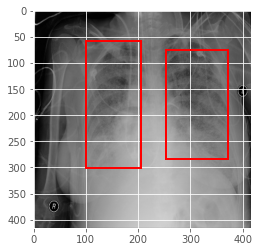

In [26]:
#Getting predicted bound boxes for the image
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)  

font = cv2.FONT_HERSHEY_PLAIN
fig,ax = plt.subplots(1)
ax.imshow(img, cmap=plt.cm.gray)
for i in range(len(boxes)):
    x, y, w, h = boxes[i]
    label = str(classes[class_ids[i]])
    
    
    
    rect = patches.Rectangle((x, y), (w) , (h) , linewidth=2, edgecolor='r', facecolor='none')

    ax.add_patch(rect)
    
plt.show()
    

In [27]:
print(class_ids)
print(confidences)
print(boxes)

[0, 0]
[0.3214382827281952, 0.4241977334022522]
[[100, 59, 105, 242], [254, 75, 118, 209]]


In [28]:
img.shape

(416, 416, 3)

### Prediction for 10 images

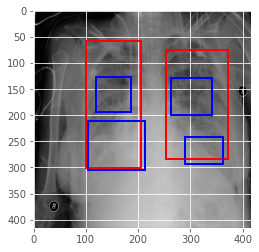

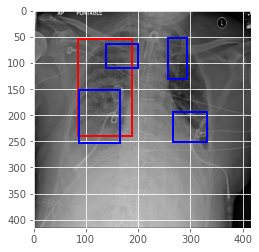

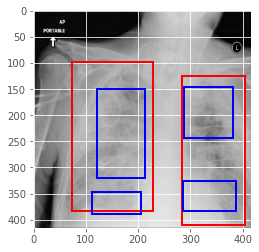

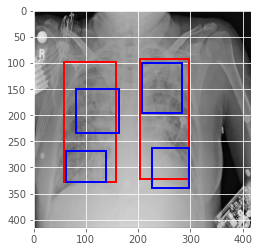

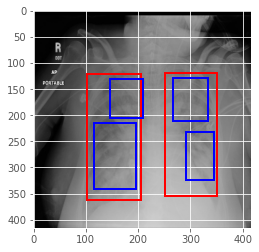

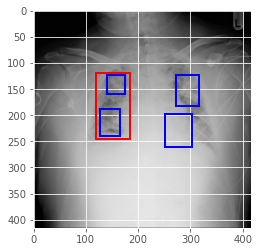

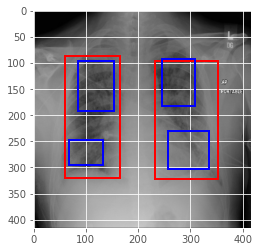

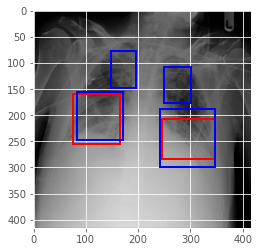

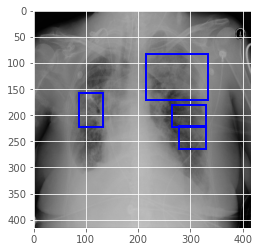

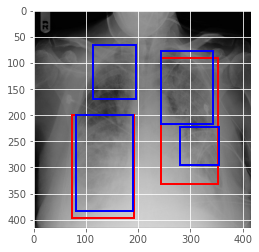

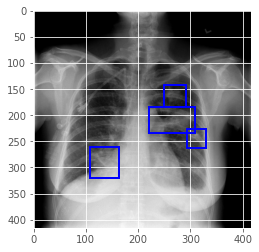

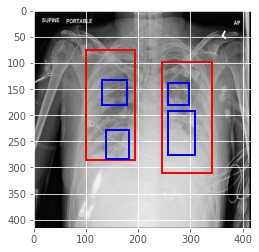

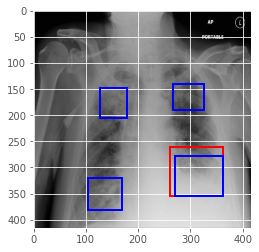

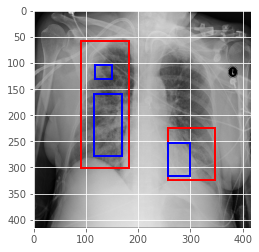

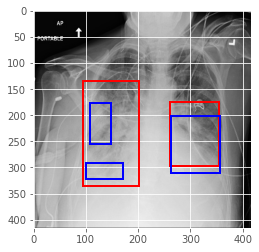

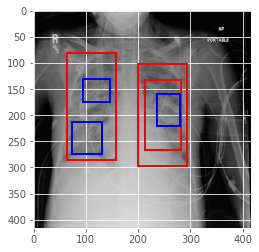

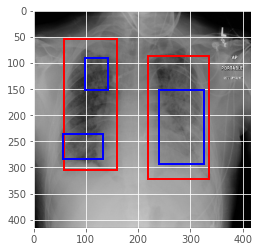

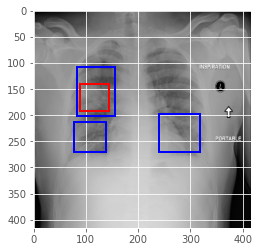

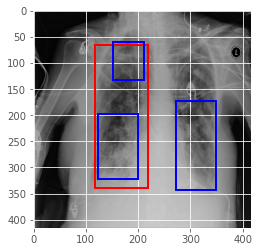

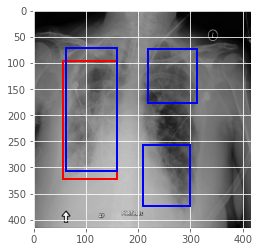

In [30]:
# For contionous 10 predictions here blue is ground truth boxes and red are predicted boxes
for i in range(20):
    img = cv2.imread("C:\\Users\\sarth\\Anaconda projects\\great learning\\AI\\Capstone\\CV\\anoteee\\images\\"+df_id_vc.iloc[i,0]+".jpg")
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    height, width, channels = img.shape

#Blob conversion
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)


    width=416
    height=416

    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.05:
            # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
            # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
            

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)  

    font = cv2.FONT_HERSHEY_PLAIN
    fig,ax = plt.subplots(1)
    ax.imshow(img, cmap=plt.cm.gray)
    for n in range(len(boxes)):
        x, y, w, h = boxes[n]
        label = str(classes[class_ids[n]])
        rect = patches.Rectangle((x, y), (w) , (h) , linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        #plt.title('prediction')
        
        
    rect1 = patches.Rectangle((coords[i][0,0] * 416/1024, coords[i][0,1] * 416/1024), (coords[i][0,2] * 416/1024) , (coords[i][0,3] * 416/1024) , linewidth=2, edgecolor='b', facecolor='none')
    rect2 = patches.Rectangle((coords[i][1,0] * 416/1024, coords[i][1,1] * 416/1024), (coords[i][1,2] * 416/1024) , (coords[i][1,3] * 416/1024) , linewidth=2, edgecolor='b', facecolor='none')
    rect3 = patches.Rectangle((coords[i][2,0] * 416/1024, coords[i][2,1] * 416/1024), (coords[i][2,2] * 416/1024) , (coords[i][2,3] * 416/1024) , linewidth=2, edgecolor='b', facecolor='none')
    rect4 = patches.Rectangle((coords[i][3,0] * 416/1024, coords[i][3,1] * 416/1024), (coords[i][3,2] * 416/1024) , (coords[i][3,3] * 416/1024) , linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    #plt.title('ground truth')

    plt.show()